## DeNA Summer Internship 2025 AIスペシャリストコース選考課題
* DeNA Summer Internship 2025 AIスペシャリストコース選考課題のノートブック
* PDF一枚にまとめるため、EDAとトレーニングを同じノートブックで行う


## 課題内容
1. 背景
あなたの所属する企業にて、不動産価格予測に基づくサービスの立ち上げを検討するこ
とになりました。
素案として、不動産の売却を検討している個人の顧客に対して、精度の高い不動産価格
推定サービスを提供することを検討しています。
あなたはデータサイエンスチームの一員として、モデリングの検討に参画します。
この検討フェーズを通じて、素案の実現可能性の調査や、より良いサービスの提供に向
けた知見の還元が期待されています。
2. 指示
与えられたデータを使って、予測モデルの検討レポートを作成してください。
レポートでは、データの傾向・性質の分析、予測モデルの作成および性能評価を行い、そ
の過程をまとめてください。
性能評価に際しては、与えられたデータと同様の性質を持つ将来データに対してどのよ
うな性能の予測が可能か、という観点で行ってください。
3. 注意
- 設定は架空のものです
- ビジネスについては、データに登場する地域、年代を対象としていることを想定し
てください
- 提出するレポートはデータサイエンスチームでレビュー・検討されることを想定し、
考察や説明を過度に平易にする必要はありません
- 本課題の評価は予測モデルの精度に限らず、課題進行の過程やビジネスレポー
トとしての質を考慮し、様々な観点から評価します

## データ
アメリカにおける不動産情報とそれに紐付く不動産価格のデータを扱って頂きます。
各カラムの意味は下記の通りです。
- date: 家の売買が成立した日
- price : 家の価格(ドル)。予測対象
- sqft_lot: 敷地面積
- sqft_living: 居住スペースの面積
- grade: 家の建築・デザインを 1 から 13 で評価したもの
- lat: 家の場所の緯度
- long: 家の場所の経度
- yr_built:建築された年
- yr_renovated: 最後にリノベーションされた年

### verの変更点
- [1.0] 一通りのEDA  
- [2.0] ベースのデータのみでトレーニング,テストまで 
    - cv: 0.18686352635400622, lb: 0.1951794332629624
    - 大きな乖離はないため一定学習できていそう
- [3.0] 特徴量の追加
    - 仮説でのアイデアを一通り実装
    - cv: 0.1909071717171483, lb: 0.19917421807093516
    - 悪化しているため、多重共線性の問題がありそうな感じがしている
    - trainを過学習している気配がある
- [3.1]
    - 'living_area_ratio', 'vacant_area',の削除
    - cv: 0.1901787799982647, lb: 0.19904439358658832
- [3.2]
    - 'renov_year_diff','build_year_diff'の削除
    - cv: 0.19056392749953852, lb: 0.19814190081273786
- [3.3]
    -  'is_renovated' の削除
    - cv: 0.19056471702787575, lb: 0.19813929178130368
- [3.4]
    - 'date_year'の削除
    - cv: 0.19056471702787575, lb: 0.19813929178130368
- [3.5]
    -  'date_month', 'date_day' の削除
    - cv: 0.1875749876397966, lb: 0.19555628597177543
    - 
- [3.6]
    - 追加特徴何もなし
    - cv: 0.18661483160191328 lb: 0.19497065058730065
    - これがベストっぽい
- [4.0]
    - 州の特徴を追加したい
    - cv:0.18620309928529236 lb: 0.19211682093262322
    
[やりたいこと]

### 0. 環境構築

In [2]:
# ====================================================
# Library
# ====================================================
from pathlib import Path
import os
import random
from tqdm import tqdm
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import reverse_geocoder as rg

import lightgbm as lgb
import datetime
import torch
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:

# ====================================================
# Configurations
# ====================================================
class CFG:
  VER = 4.0
  exp = 1.0
  AUTHOR = 'SHIMIZU'
  COMPETITION = 'DeNASummerInternship'

  INPUT_DATA_PATH = Path("../input/")
  OOF_DATA_PATH = Path("../oof/")
  MODEL_DATA_PATH = Path("../models")
  OUTPUT_DATA_PATH = Path('../output')

  METHOD_LIST = ['lightgbm']
  seed = 42
  n_folds = 5
  target_col = "price"
  metric = "RMSLE"
  metric_maximize_flag = False
  num_boost_round = 100
  early_stopping_round = 50
  verbose = 25
  regression_lgb_params = {
    'objective': 'regression',
    'metric': 'rmsle',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'seed': seed,
    'verbose':-1,
  }
  model_weight_dict = {'lightgbm': 1.0}

In [4]:
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed: int) -> None:
    """乱数のseedを固定する"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

In [5]:
# ====================================================
# LightGBM Metric
# ====================================================
def lgb_rmsle(y_pred, data):
    """RMSLE (Root Mean Squared Logarithmic Error)を計算する関数

    Args:
        y_true (np.array): 真の値
        y_pred (np.array): 予測値

    Returns:
        float: RMSLEスコア
    """
    y_true = data.get_label()
    y_pred = np.maximum(0, np.array(y_pred))  # 予測値を非負に制限

    # sklearnの関数を使用してRMSLEを計算
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return 'rmsle', rmsle, CFG.metric_maximize_flag


In [6]:
# ====================================================
# Load Dataset
# ====================================================
df = pd.read_csv(CFG.INPUT_DATA_PATH /"data.csv")

### 1.EDA

##### 前提
- **存在するデータ**
- 不動産価格とは
    - 不動産価格 = 広さ * デザイン * 立地 が基本要素だと思う
    - 広さ = **敷地面積**, **居住スペース** 
    - デザイン = 中身 + 外見
        - 中身 = **建設年**,**リノベの有無**, 部屋数, 階数, キッチン付き, トイレバス別, etc... 
        - 外見 = **デザイン**,**建設年**, 建築会社, トレンド 
    - 立地の良さ =  その家自体の立地 * 周辺環境
        - その家自体の立地 = アメリカ * 州 * **家自体の立地**
        - 周辺環境 = 家から周囲 n km 県内にある施設
##### 現状の仮説
- 予測に響きそうな要素 インパクト軸
    - Tier1. 敷地面積, 居住スペース, 家がある州, リノベ有無
    - Tier2. デザイン, 建築年, リノベ年
     
- データについて
    - 外れ値はあるかどうか? 
        - 敷地面積については基本的に広いと思うが、東京みたいな極端に狭いやつは怪しい
        - 飛び抜けて高い値段はあると思う ← ブランドやデザイナーズマンション的なもの
    - 値段について
        - 分布
            - 正規分布よりも右に裾の長い分布になりそう
        - 相関
            - 予測に響きそうな要素との相関をみたい
    - 緯度経度
        - 分布
            - アメリカにプロットして確認してみたい
            - ハワイやアラスカがあるとめんどくさそう
- 予測まわり
    - metricについて
        - 分布が偏っていそうなのでRMSEは適さない気がする
        - RMSLEとかでとるのが良さそう
    - 特徴量のアイデア **全体で1〜3時間程度を目安としてください** とのことで軽めに
        - 外部データの利用はしない
        - 集約特徴量は変数の選択が難しくなりそうなので最後にやるかどうか
        - 量的変数
            - 庭が広いのかどうか? : 居住スペース/敷地面積 or 敷地面積 - 居住スペース
            - 築年数 : date - 建設年
            - リノベ経過年数 : date - リノベ年
        - 質的変数
            - リノベ有無 : リノベ→0,1
            - 州 : 緯度経度 → 州コード 
    - tr,val,testのsplit
        - 8:2のさらに8:2で分ける感じがいいかな
        - どこをtestデータにするか?　売買成立日で並べてtimeseriesにした方が良さげか?
        - 同じ家が含まれないようにしたいけど家IDがないから、上である程度対処できることを期待

#

In [9]:
# 欠損の確認 → 欠損なし dtypeもfloat
print(df.shape)
display(df.head())
display(df.tail())
print("------欠損値の割合(%)------")
print(df.isna().sum() / len(df) * 100)

(21613, 9)


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated
0,20141013,221900,5650,1180,7,47.5112,-122.257,1955,0
1,20141209,538000,7242,2570,7,47.7210,-122.319,1951,1991
2,20150225,180000,10000,770,6,47.7379,-122.233,1933,0
3,20141209,604000,5000,1960,7,47.5208,-122.393,1965,0
4,20150218,510000,8080,1680,8,47.6168,-122.045,1987,0


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated
21608,20140521,360000,1131,1530,8,47.6993,-122.346,2009,0
21609,20150223,400000,5813,2310,8,47.5107,-122.362,2014,0
21610,20140623,402101,1350,1020,7,47.5944,-122.299,2009,0
21611,20150116,400000,2388,1600,8,47.5345,-122.069,2004,0
21612,20141015,325000,1076,1020,7,47.5941,-122.299,2008,0


------欠損値の割合(%)------
date            0.0
price           0.0
sqft_lot        0.0
sqft_living     0.0
grade           0.0
lat             0.0
long            0.0
yr_built        0.0
yr_renovated    0.0
dtype: float64


In [10]:
df.describe()

,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated
count,2.161300e+04,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,2.014390e+07,5.400881e+05,1.510697e+04,2079.899736,7.656873,47.560053,-122.213896,1971.005136,84.402258
std,4.436582e+03,3.671272e+05,4.142051e+04,918.440897,1.175459,0.138564,0.140828,29.373411,401.679240
min,2.014050e+07,7.500000e+04,5.200000e+02,290.000000,1.000000,47.155900,-122.519000,1900.000000,0.000000
25%,2.014072e+07,3.219500e+05,5.040000e+03,1427.000000,7.000000,47.471000,-122.328000,1951.000000,0.000000
50%,2.014102e+07,4.500000e+05,7.618000e+03,1910.000000,7.000000,47.571800,-122.230000,1975.000000,0.000000
75%,2.015022e+07,6.450000e+05,1.068800e+04,2550.000000,8.000000,47.678000,-122.125000,1997.000000,0.000000
max,2.015053e+07,7.700000e+06,1.651359e+06,13540.000000,13.000000,47.777600,-121.315000,2015.000000,2015.000000


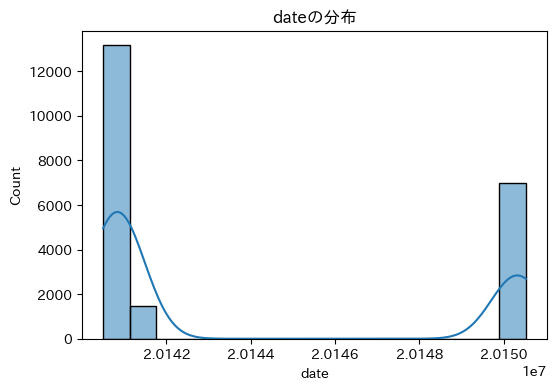

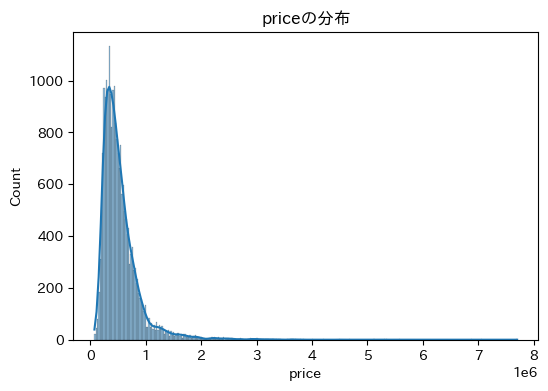

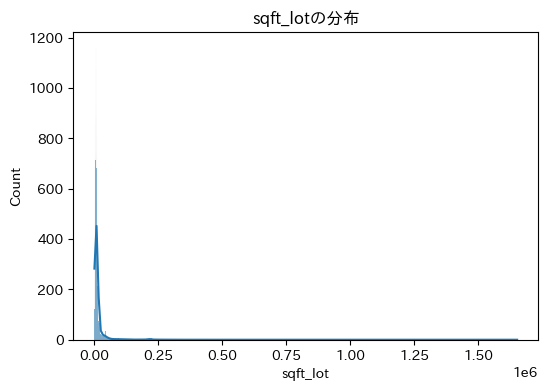

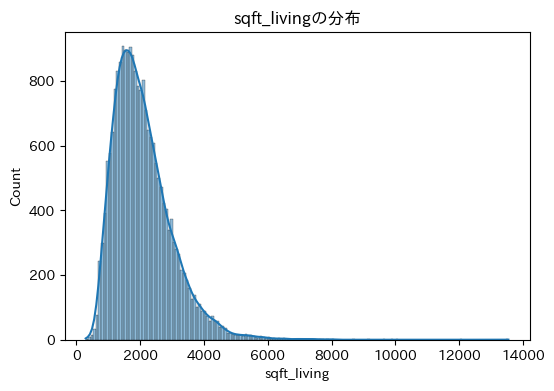

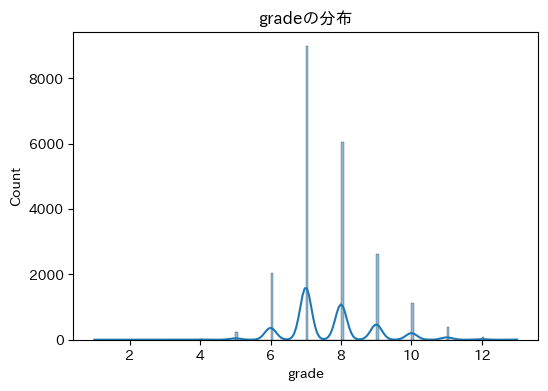

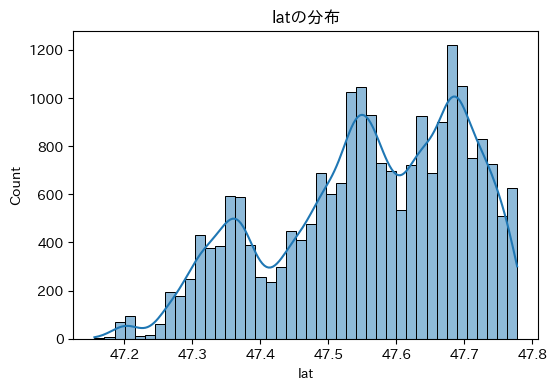

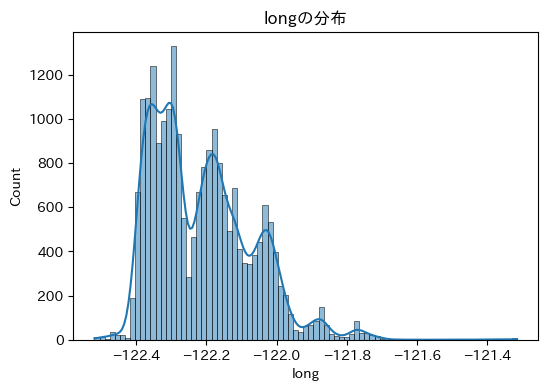

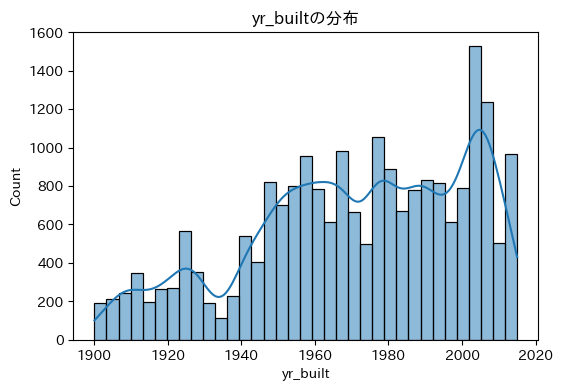

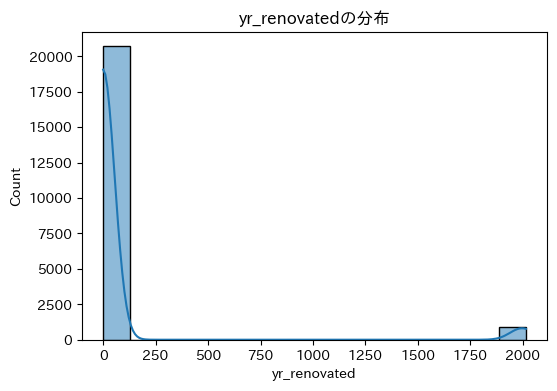

In [11]:
# 各変数の分布を可視化
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'{col}の分布')
    plt.show()

In [ ]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col == CFG.target_col:
        continue
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df[CFG.target_col])
    plt.xlabel(col)
    plt.ylabel(CFG.target_col)
    plt.title(f'Scatter plot: {col} vs {CFG.target_col}')
    plt.show()

In [ ]:
# 相関係数行列の可視化
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('相関係数行列')
plt.show()

##### 仮説に対して
- 予測に響きそうな要素 インパクト軸
    - Tier1. 敷地面積, 居住スペース, 家がある州, リノベ有無  
    → 敷地面積の相関が低い だだっ広いだけのスペースがありそう、重要なのは居住スペース

    - Tier2. デザイン, 建築年, リノベ年
- データについて
    - 外れ値はあるかどうか? 
        - 敷地面積については基本的に広いと思うが、東京みたいな極端に狭いやつは怪しい
        - 飛び抜けて高い値段はあると思う ← ブランドやデザイナーズマンション的なもの  
        →敷地面積はmaxの方は外れ値があるが、minの方は大丈夫そう  
        →値段も同様
    - 値段について
        - 分布
            - 正規分布よりも右に裾の長い分布になりそう  
            →ぱっと見変換ミスとかはなさそうな感じ
        - 相関
            - 値段と他の相関をみたい
    - 緯度経度
        - 分布
            - アメリカにプロットして確認してみたい
            - ハワイやアラスカがあるとめんどくさそう  
            →緯度経度の範囲的に本大陸の中だけっぽい

In [7]:
df['date'] = pd.to_datetime(df['date'].astype(int).astype(str), format='%Y%m%d')

In [8]:
#trainとtestデータの分割
df.sort_values(by='date', inplace=True)
df.reset_index(drop=True, inplace=True)
train_df = df.iloc[:int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]

In [11]:
def Preprocessing(train_df: pd.DataFrame) -> pd.DataFrame:
    """データの前処理を行う"""
    train_df = train_df.copy()
    def add_city_feature(input_df):
        output_df = input_df.copy()
        # reverse_geocoderは(lat, lon)のタプルのリストを受け取る
        coords = list(zip(output_df['lat'], output_df['long']))
        results = rg.search(coords)
        # 結果から都市名を取得して新しい列に追加
        output_df['city'] = [res['name'] for res in results]
        return output_df
    
    def process_date_col(input_df):
        output_df = input_df.copy()
        date_columns = [col for col in output_df.columns if 'date' in col]
        for col in date_columns:
            output_df[col + '_year'] = output_df[col].dt.year
            output_df[col + '_month'] = output_df[col].dt.month
            output_df[col + '_day'] = output_df[col].dt.day
        output_df = output_df.drop(columns=date_columns)
        return output_df
    
    def living_area_ratio(input_df):
        output_df = input_df.copy()
        output_df['living_area_ratio'] = output_df['sqft_living'] / output_df['sqft_lot']
        return output_df
    
    def vacant_area(input_df):
        output_df = input_df.copy()
        output_df['vacant_area'] = output_df['sqft_lot'] - output_df['sqft_living']
        return output_df
    
    def is_renovated(input_df):
        output_df = input_df.copy()
        output_df['is_renovated'] = output_df['yr_renovated'].notna()
        return output_df
    
    def process_renov_year(input_df):
        output_df = input_df.copy()
        # 0をNaNに置き換える（データによっては空文字 '' なども対象にする）
        output_df['yr_renovated'] = output_df['yr_renovated'].replace(0, np.nan)
        return output_df
    
    def renov_year_diff(input_df):
        output_df = input_df.copy()
        # 0よりもnan扱いの方が良いのでは? 
        output_df['renov_year_diff'] = output_df['yr_renovated'] - output_df['yr_built']
        return output_df
    
    def built_year_diff(input_df):
        output_df = input_df.copy()
        output_df['build_year_diff'] =  output_df['date_year'] - output_df['yr_built']
        return output_df
    

    train_df = add_city_feature(train_df)
    # train_df = process_date_col(train_df)
    train_df = living_area_ratio(train_df)
    # train_df = vacant_area(train_df)
    # train_df = is_renovated(train_df)
    # train_df = process_renov_year(train_df)
    # train_df = renov_year_diff(train_df)
    # train_df = built_year_diff(train_df)
    return train_df

train = Preprocessing(train_df)
test = Preprocessing(test_df)

In [13]:
train.columns

Index(['date', 'price', 'sqft_lot', 'sqft_living', 'grade', 'lat', 'long',
       'yr_built', 'yr_renovated', 'city', 'living_area_ratio'],
      dtype='object')

In [14]:
categorical_features = ['grade','city']
numerical_features = ['sqft_lot', 'sqft_living','lat', 'long','yr_built', 'yr_renovated']
#'living_area_ratio', 'vacant_area',
#'renov_year_diff','build_year_diff'
# 'is_renovated'
# 'date_year'
# 'date_month', 'date_day'
features = categorical_features + numerical_features

In [15]:
# ========================================
# Encoding features
# ========================================
le_dict = {}
for categorical_feature in tqdm(categorical_features):
    le = LabelEncoder()
    # Fit on the combined unique values from both train and test
    all_values = list(train[categorical_feature].unique()) + list(test[categorical_feature].unique())
    le.fit(all_values)

    # Transform train and test
    train[categorical_feature] = le.transform(train[categorical_feature])
    test[categorical_feature] = le.transform(test[categorical_feature])
    le_dict[categorical_feature] = le

100%|██████████| 2/2 [00:00<00:00, 191.67it/s]


In [ ]:
def add_aggrigation_feats(train, test, num_cols, cat_cols, agg_cols=['min', 'max', 'mean', 'std']):
  for col in cat_cols:
      grp_df = train.groupby(col)[num_cols].agg(agg_cols)
      grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
      train = train.merge(grp_df, on=col, how='left')
      test = test.merge(grp_df, on=col, how='left')

  return train, test

In [17]:
def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    """LightGBMの学習を行う"""
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)
    model = lgb.train(
                params = CFG.regression_lgb_params,
                train_set = lgb_train,
                num_boost_round = 500,
                valid_sets = [lgb_train, lgb_valid],
                feval = lgb_rmsle,
                callbacks=[lgb.early_stopping(stopping_rounds=50,
                                              verbose=-1)]
            )
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred


def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list, categorical_features: list):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train_df))
    oof_fold = np.zeros(len(train_df))
    tss = TimeSeriesSplit(n_splits=CFG.n_folds)
    y_true_original = train_df[CFG.target_col].values 
    all_valid_indices = []
    #sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds)
    #kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    #for fold, (train_index, valid_index) in enumerate(tss.split(train_df)):
    for fold, (train_index, valid_index) in enumerate(tss.split(train_df[features], train_df[CFG.target_col])):
        print('-'*50)
        print(f'{method} training fold {fold+1}')

        x_train = train_df[features].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_train = train_df[CFG.target_col].iloc[train_index]
        y_valid = train_df[CFG.target_col].iloc[valid_index]
        if method == 'lightgbm':
           model, valid_pred_log = lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features)

        # Save best model
        pickle.dump(model, open(CFG.MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred_log
        all_valid_indices.extend(valid_index)
        oof_fold[valid_index] = fold + 1
        del x_train, x_valid, y_train, y_valid, model, valid_pred_log
        gc.collect()

    # Compute out of folds metric
    score = np.sqrt(mean_squared_log_error(y_true_original[all_valid_indices], oof_predictions[all_valid_indices]))
    
    print(f'{method} out of folds CV RMSLE score is {score}')
    
    oof_df = pd.DataFrame({CFG.target_col: train_df[CFG.target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
    oof_df.to_csv(CFG.OOF_DATA_PATH / f'oof_{method}_seed{CFG.seed}_{CFG.AUTHOR}_ver{CFG.VER}.csv', index = False)

def Learning(train_feats):
    for method in CFG.METHOD_LIST:
        print(method)
        gradient_boosting_model_cv_training(method, train, train_feats, categorical_features)

In [20]:
Learning(features)

lightgbm
--------------------------------------------------
lightgbm training fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	training's rmsle: 0.12601	valid_1's rmsle: 0.191758


/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


--------------------------------------------------
lightgbm training fold 2
Training until validation scores don't improve for 50 rounds


/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[243]	training's rmsle: 0.137636	valid_1's rmsle: 0.181137
--------------------------------------------------
lightgbm training fold 3
Training until validation scores don't improve for 50 rounds


/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[318]	training's rmsle: 0.139731	valid_1's rmsle: 0.18707
--------------------------------------------------
lightgbm training fold 4
Training until validation scores don't improve for 50 rounds


/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[500]	training's rmsle: 0.132144	valid_1's rmsle: 0.176287
--------------------------------------------------
lightgbm training fold 5
Training until validation scores don't improve for 50 rounds


/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kslab/shimizu/.conda/envs/recsys/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[500]	training's rmsle: 0.135695	valid_1's rmsle: 0.194175
lightgbm out of folds CV RMSLE score is 0.18620309928529236


In [1]:
def lightgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        pred = model.predict(x_test)
        test_pred += pred
    return test_pred / CFG.n_folds
def gradient_boosting_model_inference(method: str, test_df: pd.DataFrame, features: list, categorical_features: list):
    x_test = test_df[features]
    if method == 'lightgbm':
        test_pred = lightgbm_inference(x_test)
    return test_pred
def Predicting(input_df: pd.DataFrame, features: list, categorical_features: list):
    output_df = input_df.copy()
    output_df['pred_prob'] = 0
    for method in CFG.METHOD_LIST:
        output_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, input_df, features, categorical_features)
        output_df['pred_prob'] += CFG.model_weight_dict[method] * output_df[f'{method}_pred_prob']
    return output_df

NameError: name 'pd' is not defined

In [22]:
test_df = Predicting(test, features, categorical_features)

In [23]:
test_df.head()

,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated,city,living_area_ratio,pred_prob,lightgbm_pred_prob
17290,2015-03-10,762450,8640,2570,6,47.5956,-122.172,1958,0,54,0.297454,675313.150356,675313.150356
17291,2015-03-10,390000,6991,1640,5,47.7255,-122.327,1967,0,66,0.234587,391417.665050,391417.665050
17292,2015-03-10,339000,8459,2350,7,47.3043,-122.349,1989,0,26,0.277811,375510.567923,375510.567923
17293,2015-03-10,194000,7700,1760,5,47.3299,-122.318,1962,0,26,0.228571,247814.796190,247814.796190
17294,2015-03-10,641500,9084,1000,5,47.5007,-122.382,1950,0,75,0.110084,354724.811777,354724.811777


In [24]:
score = np.sqrt(mean_squared_log_error(test_df[CFG.target_col],test_df["pred_prob"]))
print(f"RMSLE: {score}")

RMSLE: 0.19211682093262322


In [57]:
sample_submit = pd.read_csv(CFG.SUB_FILE_PATH, index_col=0, header=None) # 応募用サンプルファイル
sample_submit[1] = test_df[["pred_prob"]].values
sample_submit.to_csv(CFG.SUB_DATA_PATH / f'exp{CFG.exp}_seed{CFG.seed}_ver{CFG.VER}_{CFG.AUTHOR}_submission.csv', header=False)

In [ ]:
model = pickle.load(open(CFG.MODEL_DATA_PATH / f'lightgbm_fold1_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
importance_df = pd.DataFrame(model.feature_importance(), index=model.feature_name(), columns=['importance'])
importance_df['importance'] = importance_df['importance'] / np.sum(importance_df['importance'])
importance_df.sort_values('importance', ascending=False)